In [1]:
import os
import sys
from collections import defaultdict
import gzip
import pandas as pd
import re
import csv
import seaborn
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tqdm
GTF_HEADER  = ['seqname', 'source', 'feature', 'start', 'end', 'score',
               'strand', 'frame']
R_SEMICOLON = re.compile(r'\s*;\s*')
R_COMMA     = re.compile(r'\s*,\s*')
R_KEYVALUE  = re.compile(r'(\s+|\s*=\s*)')


def dataframe(filename):
    """Open an optionally gzipped GTF file and return a pandas.DataFrame.
    """
    # Each column is a list stored as a value in this dict.
    result = defaultdict(list)

    for i, line in enumerate(lines(filename)):
        for key in line.keys():
            # This key has not been seen yet, so set it to None for all
            # previous lines.
            if key not in result:
                result[key] = [None] * i

        # Ensure this row has some value for each column.
        for key in result.keys():
            result[key].append(line.get(key, None))

    return pd.DataFrame(result)


def lines(filename):
    """Open an optionally gzipped GTF file and generate a dict for each line.
    """
    fn_open = gzip.open if filename.endswith('.gz') else open

    with fn_open(filename) as fh:
        for line in fh:
            if line.startswith('#'):
                continue
            else:
                yield parse(line)


def parse(line):
    """Parse a single GTF line and return a dict.
    """
    result = {}

    fields = line.rstrip().split('\t')

    for i, col in enumerate(GTF_HEADER):
        result[col] = _get_value(fields[i])

    # INFO field consists of "key1=value;key2=value;...".
    infos = [x for x in re.split(R_SEMICOLON, fields[8]) if x.strip()]

    for i, info in enumerate(infos, 1):
        # It should be key="value".
        try:
            key, _, value = re.split(R_KEYVALUE, info, 1)
        # But sometimes it is just "value".
        except ValueError:
            key = 'INFO{}'.format(i)
            value = info
        # Ignore the field if there is no value.
        if value:
            result[key] = _get_value(value)

    return result


def _get_value(value):
    if not value:
        return None

    # Strip double and single quotes.
    value = value.strip('"\'')

    # Return a list if the value has a comma.
    if ',' in value:
        value = re.split(R_COMMA, value)
    # These values are equivalent to None.
    elif value in ['', '.', 'NA']:
        return None

    return value



In [7]:
import cleanome
import cleanome.debug_gtf

In [2]:
species={'mouse':'/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/genome/kallisto/mm10/Mus_musculus.GRCm38.100.gtf',
        'human':'/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/genome/kallisto/gencodev33/gencode.v33.annotation.gtf',
        'macaque':'/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/genome/kallisto/CAT_chang/Rhesus.addgenes.gtf'
}
        #'chimp':'/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/genomes/cleanome_genomes/ncbi_genomes/9598-Pan_troglodytes/genomic.gtf',
        #'marmoset':'/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/genomes/cleanome_genomes/ncbi_genomes/9483-Callithrix_jacchus/genomic.gtf'


In [5]:
feature_names={'mouse':'gene',
        'human':'gene',
        'macaque':'gene'}
        #'chimp':'exon',
        #'marmoset':'exon'

In [8]:
gtfs={}
for k in species.keys():
    print(k)
    gtfs[k] = cleanome.debug_gtf.polars_to_pandas(cleanome.debug_gtf.gtfparse_gtf_file(species[k]))




mouse


INFO:root:Extracted GTF attributes: ['gene_id', 'gene_version', 'gene_name', 'gene_source', 'gene_biotype', 'havana_gene', 'havana_gene_version', 'transcript_id', 'transcript_version', 'transcript_name', 'transcript_source', 'transcript_biotype', 'havana_transcript', 'havana_transcript_version', 'tag', 'transcript_support_level', 'exon_number', 'exon_id', 'exon_version', 'ccds_id', 'protein_id', 'protein_version']


human


INFO:root:Extracted GTF attributes: ['gene_id', 'gene_type', 'gene_name', 'level', 'hgnc_id', 'havana_gene', 'transcript_id', 'transcript_type', 'transcript_name', 'transcript_support_level', 'tag', 'havana_transcript', 'exon_number', 'exon_id', 'ont', 'protein_id', 'ccdsid']


macaque


INFO:root:Extracted GTF attributes: ['transcript_id', 'gene_id', 'gene_name', 'exon_id']


In [9]:
orthos=pd.read_csv('~/utils/HOM_AllOrganism.rpt',sep='\t')
orthos=orthos.loc[orthos['NCBI Taxon ID'].isin([10090,9606]),:]
classcounts=orthos['DB Class Key'].value_counts()
one2one=classcounts.index[list(classcounts==2)]
orthos=orthos.loc[orthos['DB Class Key'].isin(one2one),:]

htab=orthos.loc[orthos['NCBI Taxon ID']==9606,:]
mtab=orthos.loc[orthos['NCBI Taxon ID']==10090,:]
genemapping=dict(zip([x.upper() for x in mtab['Symbol']],htab['Symbol']))


In [10]:
for k in gtfs.keys():
    print(gtfs[k].columns)


Index(['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand',
       'frame', 'gene_id', 'gene_version', 'gene_name', 'gene_source',
       'gene_biotype', 'havana_gene', 'havana_gene_version', 'transcript_id',
       'transcript_version', 'transcript_name', 'transcript_source',
       'transcript_biotype', 'havana_transcript', 'havana_transcript_version',
       'tag', 'transcript_support_level', 'exon_number', 'exon_id',
       'exon_version', 'ccds_id', 'protein_id', 'protein_version'],
      dtype='object')
Index(['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand',
       'frame', 'gene_id', 'gene_type', 'gene_name', 'level', 'hgnc_id',
       'havana_gene', 'transcript_id', 'transcript_type', 'transcript_name',
       'transcript_support_level', 'tag', 'havana_transcript', 'exon_number',
       'exon_id', 'ont', 'protein_id', 'ccdsid'],
      dtype='object')
Index(['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand',
       'frame', 'transc

In [11]:
transcript_gtfs={}
for k in gtfs.keys():
    print(k)
    transcript_gtfs[k]=gtfs[k].loc[gtfs[k]['feature']==feature_names[k],['seqname','start','feature','gene_name']]


mouse
human
macaque


In [15]:
for k in gtfs.keys():
    transcript_gtfs[k]=transcript_gtfs[k].loc[~transcript_gtfs[k]['gene_name'].duplicated(),:]



In [16]:
#convert mouse ids to standard ids
transcript_gtfs['mouse']['gene_name']=transcript_gtfs['mouse']['gene_name'].str.upper().replace(genemapping)

In [17]:
for k in transcript_gtfs.keys():
    print(transcript_gtfs[k])

            seqname    start feature       gene_name
0                 1  3073253    gene   4933401J01RIK
3                 1  3102016    gene         GM26206
6                 1  3205901    gene            XKR4
24                1  3252757    gene         GM18956
27                1  3365731    gene         GM37180
...             ...      ...     ...             ...
1869533  GL456385.1    32719    gene  CAAA01205117.1
1869536  GL456372.1    13262    gene  CAAA01098150.1
1869539  GL456381.1    16623    gene  CAAA01064564.1
1869542  JH584292.1     3536    gene        VMN2R122
1869618  JH584295.1       66    gene  CAAA01147332.1

[55367 rows x 4 columns]
        seqname  start feature    gene_name
0          chr1  11869    gene      DDX11L1
12         chr1  14404    gene       WASH7P
25         chr1  17369    gene    MIR6859-1
28         chr1  29554    gene  MIR1302-2HG
36         chr1  30366    gene    MIR1302-2
...         ...    ...     ...          ...
2909513    chrM  14149    gene

In [18]:
for k in transcript_gtfs.keys():
    print(transcript_gtfs[k]['gene_name'].unique())


['4933401J01RIK' 'GM26206' 'XKR4' ... 'CAAA01064564.1' 'VMN2R122'
 'CAAA01147332.1']
['DDX11L1' 'WASH7P' 'MIR6859-1' ... 'MT-CYB' 'MT-TT' 'MT-TP']
['PGBD2' 'RNU6-1205P' 'AL672291.1' ... 'ND4L' 'ND5' 'ND6']


In [19]:
for k in transcript_gtfs.keys():
    transcript_gtfs[k]['start']=transcript_gtfs[k]['start'].astype(int)

In [20]:
for k in transcript_gtfs.keys():
    transcript_gtfs[k]=transcript_gtfs[k].sort_values(['seqname','start']).reset_index()


In [21]:
for k in transcript_gtfs.keys():
    transcript_gtfs[k]['linear_rank']=transcript_gtfs[k].index.astype(int)


In [23]:
for k in transcript_gtfs.keys():
    transcript_gtfs[k].index=transcript_gtfs[k]['gene_name']
    transcript_gtfs[k]['chr_gene']=transcript_gtfs[k]['gene_name'].astype(str)+"__"+transcript_gtfs[k]['seqname'].astype(str)


In [24]:
transcript_gtfs

{'mouse':                  index seqname     start feature      gene_name  linear_rank  \
 gene_name                                                                      
 4933401J01RIK        0       1   3073253    gene  4933401J01RIK            0   
 GM26206              3       1   3102016    gene        GM26206            1   
 XKR4                 6       1   3205901    gene           XKR4            2   
 GM18956             24       1   3252757    gene        GM18956            3   
 GM37180             27       1   3365731    gene        GM37180            4   
 ...                ...     ...       ...     ...            ...          ...   
 GM4242         1868498      19  61232424    gene         GM4242        55362   
 GM18999        1868502      19  61255967    gene        GM18999        55363   
 GM50357        1868506      19  61257534    gene        GM50357        55364   
 GM21060        1868509      19  61296902    gene        GM21060        55365   
 GM20762        186

In [25]:
#set(transcript_gtfs['human']['gene_name']).intersection(transcript_gtfs['mouse']['gene_name'])

In [26]:
species_pairs=[['human','humanscramble'],
               ['human','macaque'],
               ['human','mouse'],
               ['macaque','mouse']]
               # ['macaque','mouse'],
               # ['human','chimp']]

['human', 'humanscramble']


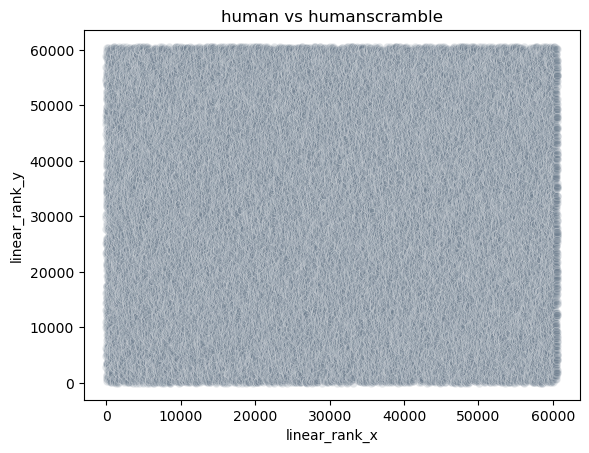

['human', 'macaque']


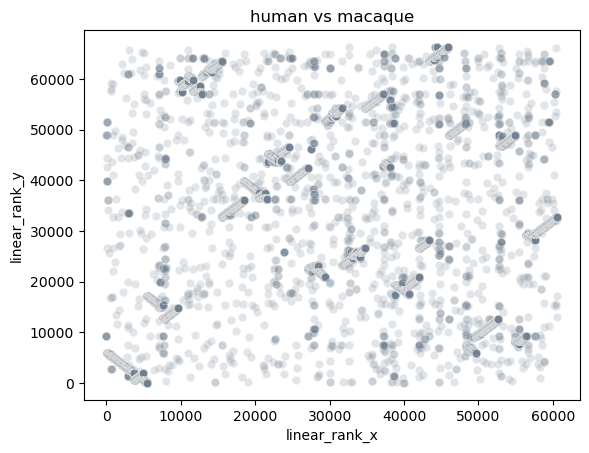

['human', 'mouse']


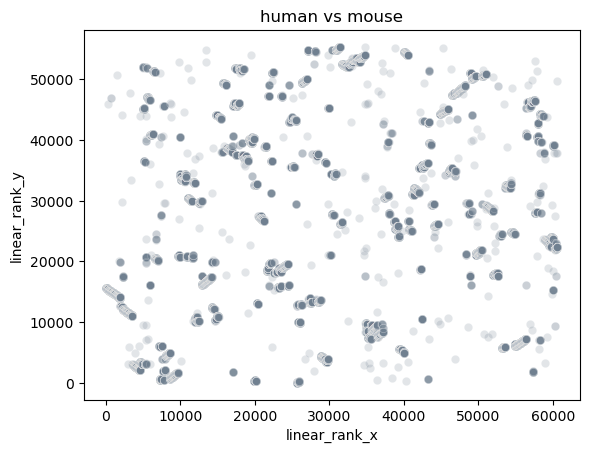

['macaque', 'mouse']


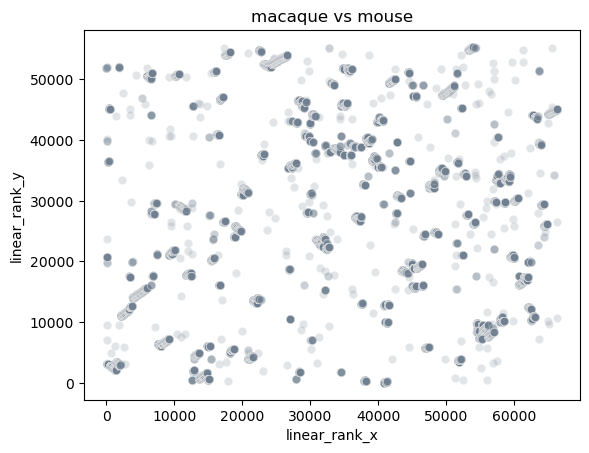

In [27]:
for pairs in species_pairs:
    print(pairs)
    if pairs[1]=='humanscramble':
        scrambled_gtf=transcript_gtfs['human'].copy(deep=True)
        scrambled_gtf['linear_rank']=list(np.random.choice(scrambled_gtf['linear_rank'],size=len(scrambled_gtf['linear_rank']),replace=False))
        merged=pd.merge(transcript_gtfs['human'], scrambled_gtf, left_index=True, right_index=True)
    else:
        merged=pd.merge(transcript_gtfs[pairs[0]], transcript_gtfs[pairs[1]], left_index=True, right_index=True)
    seaborn.scatterplot(x='linear_rank_x',y='linear_rank_y',data=merged,alpha=.2,color='slategray')
    plt.title(pairs[0]+' vs ' +pairs[1])
    plt.show()

# Calculate gene neighborhood jaccards

In [28]:
dist=1e5
neighbors=defaultdict(lambda: defaultdict(list))
for k in transcript_gtfs.keys():
    transcript_gtfs[k].index=transcript_gtfs[k]['chr_gene']
    for g in tqdm.tqdm(transcript_gtfs[k].index.astype(str)):
        try:
            gene=re.sub('__.*$','',g)
            gene_info=transcript_gtfs[k].loc[g,:]
            chrom=gene_info['seqname']
            if len(gene_info.shape)!=1:
                chrom=chrom[0]
            on_chrom=transcript_gtfs[k].loc[:,'seqname']==chrom
            within_dist=(transcript_gtfs[k].loc[g,'start'].mean()-transcript_gtfs[k].loc[:,'start']).abs()<=dist
            neighbors[k][gene].append(transcript_gtfs[k].loc[within_dist&on_chrom&(transcript_gtfs[k]['gene_name']!=gene),:])
        except:
            pass

  1%|▏         | 703/55367 [00:04<06:06, 149.11it/s]/scratch/fast/10803/ipykernel_1906625/3489380788.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  chrom=chrom[0]
100%|██████████| 66364/66364 [05:02<00:00, 219.10it/s]


In [29]:
for k in neighbors.keys():
    for j in neighbors[k].keys():
        neighbors[k][j]=pd.concat(neighbors[k][j],axis=0)

In [30]:
species_pairs=[['human','macaque'],
               ['macaque','mouse'],
               ['mouse','human']]
              #  ['human','chimp'],
              # ['human','marmoset']]

In [31]:
jaccards=defaultdict(dict)
for i,pairs in enumerate(species_pairs):
    k=pairs[0]+'_'+pairs[1]
    print(k)
    for g in (set(neighbors[pairs[0]].keys())):       
        try:
            set1=set(neighbors[pairs[0]][g]['gene_name'])
            set2=set(neighbors[pairs[1]][g]['gene_name'])
            jaccards[k][g]=len(set1&set2)/len(set1|set2)
        except:
            jaccards[k][g]=np.nan


human_macaque
macaque_mouse
mouse_human


In [32]:
for k in jaccards.keys():
    print(k)

human_macaque
macaque_mouse
mouse_human


In [33]:
df=pd.DataFrame(jaccards)

In [34]:
pd.melt(df)

,variable,value
0,human_macaque,0.500000
1,human_macaque,NaN
2,human_macaque,NaN
3,human_macaque,0.705882
4,human_macaque,0.666667
...,...,...
329146,mouse_human,NaN
329147,mouse_human,NaN
329148,mouse_human,NaN
329149,mouse_human,NaN


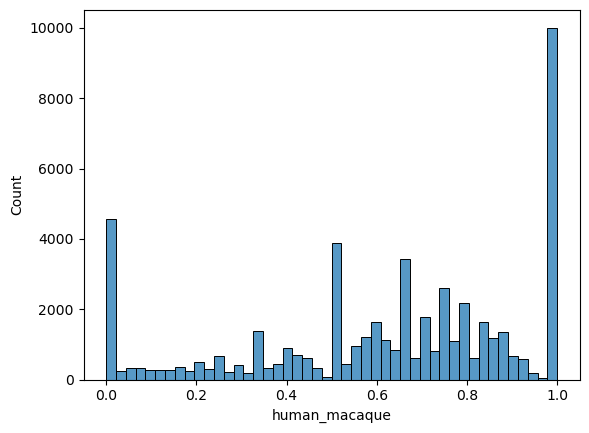

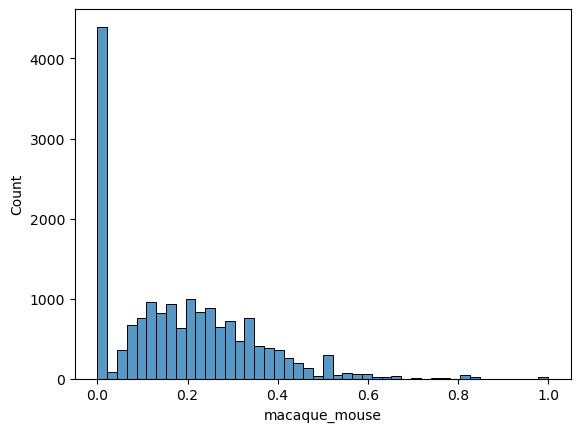

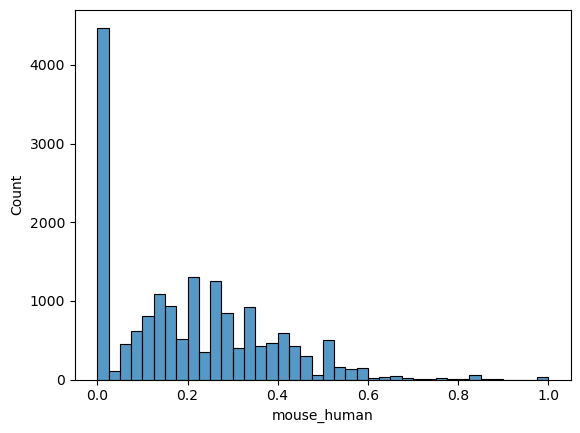

In [35]:
for c in df.columns:
    seaborn.histplot(df[c])
    plt.xlabel(c)
    plt.show()

<Axes: xlabel='value', ylabel='Count'>

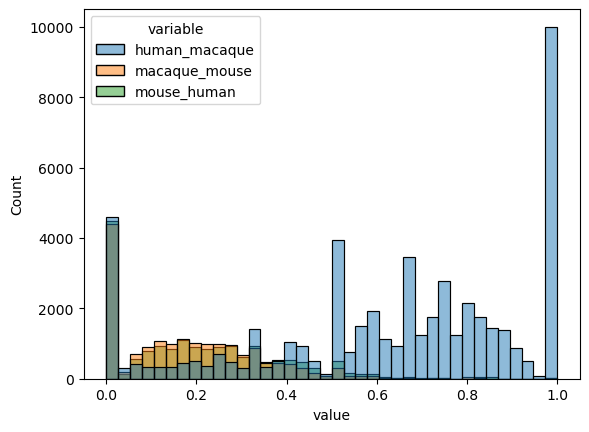

In [36]:
seaborn.histplot(data=pd.melt(df),x='value',hue='variable')

In [37]:
df.to_csv('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/gene_lists/gene_order_jaccards.csv')

In [38]:
merged.groupby('seqname_y')['seqname_x'].value_counts().unstack().fillna(0)

/scratch/fast/10803/ipykernel_1906625/2554077531.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged.groupby('seqname_y')['seqname_x'].value_counts().unstack().fillna(0)


seqname_x,chr1,chr10,chr10_1617X1637_random,chr10_1633X1653_random,chr10_1856X1878_random,chr10_2113X2137_random,chr10_2158X2183_random,chr10_2586X2616_random,chr10_2594X2625_random,chr10_2657X2688_random,...,chrUn_930X948_random,chr1_2016X2040_random,chr7_2740X2771_random,chr19_2041X2065_random,chr19_2936X2977_random,chrUn_1265X1285_random,chrUn_13X16_random,chrUn_1948X1971_random,chr19_2557X2587_random,chr20
seqname_y,,,,,,,,,,,,,,,,,,,,,
1,502,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,506,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
X,2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,508,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
4,720,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,31,26,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,25,12,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,171
10,0,30,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


/scratch/fast/10803/ipykernel_1906625/2559808705.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seaborn.heatmap(merged.groupby('seqname_y')['seqname_x'].value_counts(normalize=True).unstack().T.fillna(0),cmap='coolwarm')


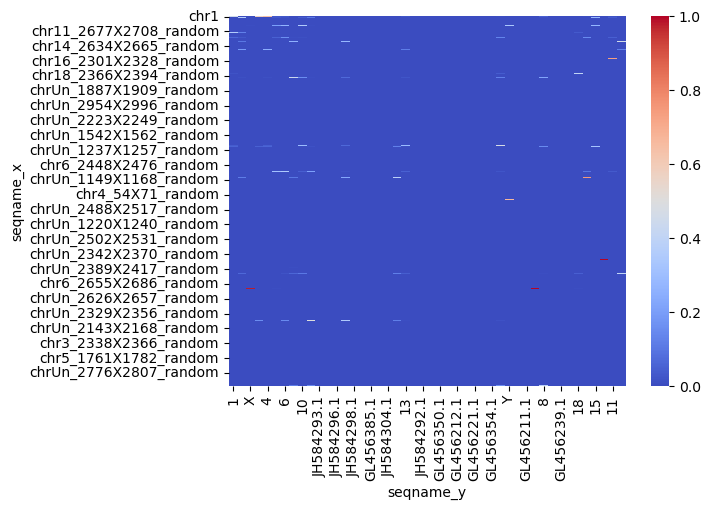

/scratch/fast/10803/ipykernel_1906625/2559808705.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seaborn.heatmap(merged.groupby('seqname_x')['seqname_y'].value_counts(normalize=True).unstack().fillna(0),cmap='coolwarm')


<Axes: xlabel='seqname_y', ylabel='seqname_x'>

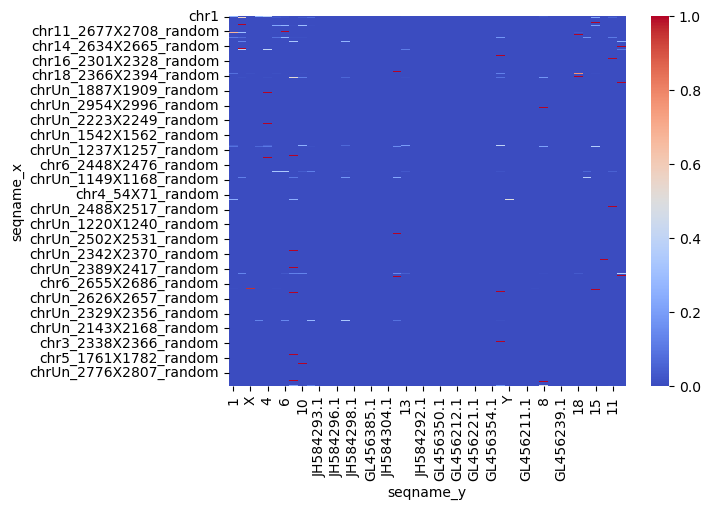

In [39]:
seaborn.heatmap(merged.groupby('seqname_y')['seqname_x'].value_counts(normalize=True).unstack().T.fillna(0),cmap='coolwarm')
plt.show()
seaborn.heatmap(merged.groupby('seqname_x')['seqname_y'].value_counts(normalize=True).unstack().fillna(0),cmap='coolwarm')


In [40]:
merged['seqname_x']=[x[0] for x in merged['seqname_x'].str.split('_')]


In [41]:
adj_xy=merged.groupby('seqname_y')['seqname_x'].value_counts(normalize=True).T.fillna(0).unstack().stack().reset_index()
adj_yx=merged.groupby('seqname_x')['seqname_y'].value_counts(normalize=True).fillna(0).unstack().stack().reset_index()

/scratch/fast/10803/ipykernel_1906625/2659520625.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adj_xy=merged.groupby('seqname_y')['seqname_x'].value_counts(normalize=True).T.fillna(0).unstack().stack().reset_index()
